# Homework 7: Sentiment Classification with Pre-trained and Re-trained GloVe Embeddings

## Due: Midnight on October 19th @ Midnight (with 2-hour grace period) and worth 85 points.

In this notebook, we’ll continue with the investigation of text classification using "Bag of Embeddings" models and the IMDB movie review dataset.
We'll focus on unfrozen embeddings, which refine the embedding space based on your dataset.

You'll do three problems:

* **Problem One:** Build a baseline model with unfrozen embeddings and experiment with architectural and training adjustments to improve performance.
* **Problem Two:** Investigate how increasing the maximum message length and vocabulary size affects model accuracy and generalization.
* **Problem Three:** Examine the impact of changing the embedding dimension on model performance.


In each problem, you'll report your best validation accuracy and reflect on what you have learned.

### Useful Imports

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from collections import Counter


from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Sequential
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.layers import LayerNormalization, MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,GlobalMaxPooling1D, Flatten
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import StratifiedShuffleSplit


# Reproducibility

random_seed = 42

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# utility code

from datetime import datetime

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

'''  How to time your code
# start timer
start_time = time.time()

<your code here>

# Record end time and print execution time
print(f"Execution Time: " + format_time(time.time()-start_time))
'''

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far
- We've also added  `

In [3]:
def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()


###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Uses "binary_crossentropy" for binary classification task.
- Assumes `X_train,y_train,X_test,y_test` already defined, will access them as global variables.
- If `X_val` and `y_val` defined, will use those, else assumes `validation_split = 0.2` in `fit`


**Note:** See the end of the notebook for results and parameter settings.

In [4]:
def train_and_test(model,
                   title         = "Learning Curves",
                   epochs        = 200,                   # Just needs to be bigger than early stopping point
                   optimizer     = "Adam",
                   lr_schedule   = 1e-3,                  # Adam defaults
                   clipnorm      = None,
                   batch_size    = 128,
                   loss          = "binary_crossentropy",
                   metrics       = ["accuracy"],
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")

    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule,clipnorm=clipnorm)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer = opt,
                  loss      = loss,
                  metrics   = metrics
                 )



    if use_early_stopping:
        early_stop = EarlyStopping(
            monitor              = 'val_loss',
            patience             = patience,
            min_delta            = min_delta,
            restore_best_weights = True,               # this will mean that the model which produced the smallest validation loss will be returned
            verbose              = verbose
        )
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    # If X_val defined, then  use it, else assume val is split from train

    if 'X_val' in globals():
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val, y_val),
                            callbacks=cbs,
                            verbose=verbose
                           )
    else:
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=0.2,
                            callbacks=cbs,
                            verbose=verbose
                           )

    # Plot training history
    plot_learning_curves(history, title=title)

    # Find epoch with minimum validation loss
    min_val_epoch = np.argmin(history.history['val_loss'])
    # Retrieve the values at that epoch
    min_val_loss = history.history['val_loss'][min_val_epoch]
    # Get corresponding validation accuracy at that epoch
    val_acc_at_min_loss = history.history['val_accuracy'][min_val_epoch]

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    # Print out results

    print(f"\nFinal Training Loss:            {history.history['loss'][-1]:.4f}")
    print(f"Final Training Accuracy:        {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Loss:          {history.history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy:      {history.history['val_accuracy'][-1]:.4f}")
    print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
    print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Accuracy Gap: {abs(val_acc_at_min_loss - test_accuracy):.6f}")

    # Store accuracy in results
    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

    # Store all information about run in parameter_settings

    global parameter_settings
    entry = {
        "title": title,
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "epochs": int(epochs),
        "optimizer": optimizer,
        "lr_schedule": lr_schedule,
        "clipnorm": clipnorm,
        "loss": loss,
        "batch_size": batch_size,
        "use_early_stopping": use_early_stopping,
        "patience": patience,
        "min_delta": min_delta,
        "callbacks": _summarize_callbacks(callbacks),
        "Final Training Loss" : history.history['loss'][-1],
        "Final Training Accuracy" : history.history['accuracy'][-1],
        "Final Val Loss" : history.history['val_loss'][-1],
        "Final Val Accuracy" : history.history['val_accuracy'][-1],
        "Min Val Loss" : min_val_loss,
        "Min Val Loss Epoch" : min_val_epoch,
        "Val Acc @ Min Loss" : val_acc_at_min_loss,
        "Test Loss" : test_loss,
        "Test Acc" : test_accuracy,
        "Val-Test Accuracy Gap:" : abs(val_acc_at_min_loss - test_accuracy)
    }
    parameter_settings.setdefault(title, []).append(entry)

    if return_history:
        return history

def _summarize_callbacks(cbs):
    if cbs is None:
        return None
    out = []
    for cb in cbs:
        name = getattr(cb, "__class__", type(cb)).__name__
        info = {"class": name}
        # grab a few common attributes if present
        for attr in ("monitor", "mode", "patience", "min_delta",
                     "factor", "min_lr", "verbose", "cooldown"):
            if hasattr(cb, attr):
                info[attr] = getattr(cb, attr)
        out.append(info)
    return out

results = {}
parameter_settings = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

In [5]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-5,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

#  put in the callbacks list:

#    train_and_test(model, title="Learning Curves",callbacks=[reduce_lr])


### Prelude:  A little EDA: Distribution of review lengths and coverage by max vocabulary size

You will use this to think about where the set parameters for maximum review length and the maximum number of unique tokens to use.


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total unique words in Keras IMDB word_index (corpus-wide): 88,584
Num training reviews: 25,000
Max length: 2,494 tokens
Mean length: 238.7 tokens
Median length: 178 tokens
90th percentile: 467 tokens
95th percentile: 610 tokens
99th percentile: 926 tokens


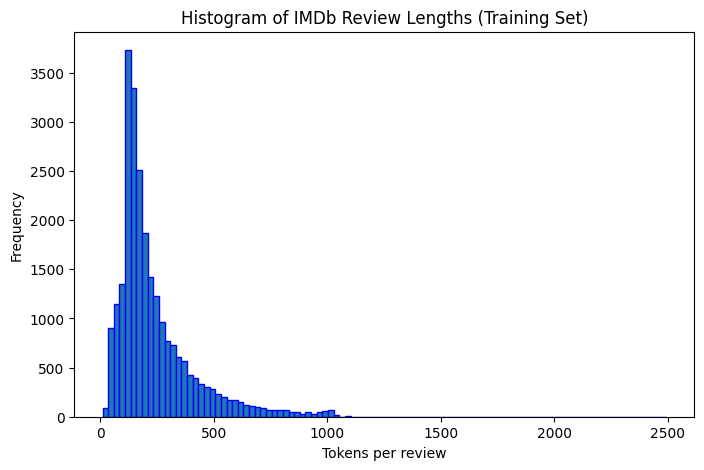


Unique word types in TRAIN (id >= 3): 88,583
Total word tokens in TRAIN (id >= 3): 5,942,840

Coverage metrics by candidate vocab size (TRAIN split):
training_vocabulary_size= 2,000 | coverage= 82.84% | OOV= 17.16% | types kept=  1,997 | tokens kept= 4,922,766
training_vocabulary_size= 5,000 | coverage= 90.03% | OOV=  9.97% | types kept=  4,997 | tokens kept= 5,350,551
training_vocabulary_size=10,000 | coverage= 94.25% | OOV=  5.75% | types kept=  9,997 | tokens kept= 5,601,261
training_vocabulary_size=20,000 | coverage= 97.22% | OOV=  2.78% | types kept= 19,997 | tokens kept= 5,777,376
training_vocabulary_size=30,000 | coverage= 98.37% | OOV=  1.63% | types kept= 29,997 | tokens kept= 5,846,141
training_vocabulary_size=50,000 | coverage= 99.32% | OOV=  0.68% | types kept= 49,997 | tokens kept= 5,902,246
training_vocabulary_size=70,000 | coverage= 99.69% | OOV=  0.31% | types kept= 69,997 | tokens kept= 5,924,254
training_vocabulary_size=88,584 | coverage=100.00% | OOV=  0.00% | types

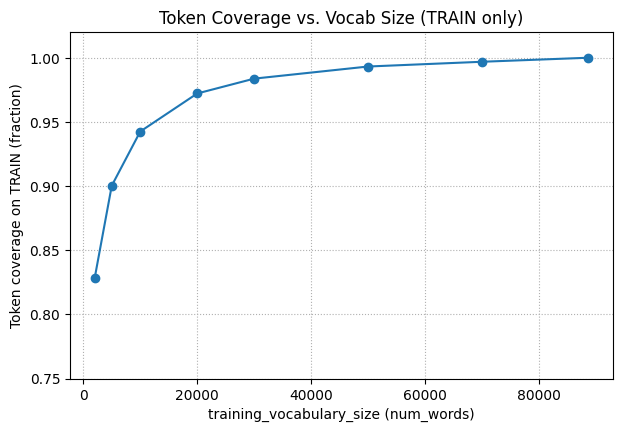

In [6]:
# IMDB vocab & length stats + coverage table + single coverage plot

from tensorflow.keras.datasets import imdb
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# Load IMDB with NO cap (so we can measure coverage fairly)
# ---------------------------------------
(X_tr, y_tr), _ = imdb.load_data()

# ---------------------------------------
# 1) Global vocab stats (from Keras word_index)
# ---------------------------------------
word_index = imdb.get_word_index()  # mapping: word -> rank (lower rank = more frequent)
total_unique_words_corpus = len(word_index)  # across the full IMDB corpus Keras ships
print(f"Total unique words in Keras IMDB word_index (corpus-wide): {total_unique_words_corpus:,}")

# ---------------------------------------
# 2) Training review length stats + histogram (students pick max_text_length)
# ---------------------------------------
lengths = np.fromiter((len(r) for r in X_tr), dtype=np.int32)
print(f"Num training reviews: {len(lengths):,}")
print(f"Max length: {lengths.max():,} tokens")
print(f"Mean length: {lengths.mean():.1f} tokens")
print(f"Median length: {np.median(lengths):.0f} tokens")
for q in (90, 95, 99):
    print(f"{q}th percentile: {int(np.percentile(lengths, q))} tokens")

plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=100, edgecolor='b')
plt.title("Histogram of IMDb Review Lengths (Training Set)")
plt.xlabel("Tokens per review")
plt.ylabel("Frequency")
plt.show()

# ---------------------------------------
# 3) Training-only frequency counts for real words (ids >= 3)
#    IMDB ID conventions: 0=<PAD>, 1=<START>, 2=<OOV>, >=3 actual words
# ---------------------------------------
def iter_tokens(seqs):
    for s in seqs:
        for t in s:
            yield t

train_counts = Counter(t for t in iter_tokens(X_tr) if t >= 3)

# Frequency list (descending) and cumulative token coverage
freqs = np.array(sorted(train_counts.values(), reverse=True), dtype=np.int64)
cum_tokens = np.cumsum(freqs)
total_tokens_train_words = int(cum_tokens[-1])
num_unique_words_train = int(len(freqs))

print(f"\nUnique word types in TRAIN (id >= 3): {num_unique_words_train:,}")
print(f"Total word tokens in TRAIN (id >= 3): {total_tokens_train_words:,}")

# ---------------------------------------
# 4) Coverage helper for a given num_words cap (Keras convention)
#    Valid word ids are [3, num_words_cap-1] → ranks [1 .. num_words_cap-3]
# ---------------------------------------
def coverage_for_cap(num_words_cap: int):
    kept_types = max(0, min(num_words_cap - 3, num_unique_words_train))
    kept_tokens = int(cum_tokens[kept_types - 1]) if kept_types > 0 else 0
    oov_tokens = total_tokens_train_words - kept_tokens
    coverage = kept_tokens / total_tokens_train_words if total_tokens_train_words > 0 else 0.0
    oov_share = oov_tokens / total_tokens_train_words if total_tokens_train_words > 0 else 0.0
    return dict(
        cap=num_words_cap,
        kept_tokens=kept_tokens,
        kept_types=kept_types,
        coverage=coverage,
        oov_share=oov_share
    )

# ---------------------------------------
# 5) Candidate vocab sizes: ASCII table + single coverage plot
# ---------------------------------------
candidate_caps = [2_000, 5_000, 10_000, 20_000, 30_000, 50_000,70_000,88_584]  # students can edit
rows = [coverage_for_cap(k) for k in candidate_caps]

print("\nCoverage metrics by candidate vocab size (TRAIN split):")
for r in rows:
    print(f"training_vocabulary_size={r['cap']:>6,} | coverage={r['coverage']*100:6.2f}% | "
          f"OOV={r['oov_share']*100:6.2f}% | types kept={r['kept_types']:>7,} | tokens kept={r['kept_tokens']:>10,}")

plt.figure(figsize=(7, 4.5))
plt.plot(candidate_caps, [r['coverage'] for r in rows], marker='o')
plt.xlabel("training_vocabulary_size (num_words)")
plt.ylabel("Token coverage on TRAIN (fraction)")
plt.title("Token Coverage vs. Vocab Size (TRAIN only)")
plt.grid(True, linestyle=":")
plt.ylim(0.75, 1.02)
plt.show()


### Load and preprocess dataset

Here is where you can set the
- `training_vocabulary_size` and
- `max_text_length`

In [7]:
# Load and preprocess dataset into padded sequences of token IDs

training_vocabulary_size = 50_000               # <-----
max_text_length          = 500                  # <-----

(X_tr, y_tr), (X_te, y_te) = imdb.load_data( num_words = training_vocabulary_size )

X  = np.concatenate([X_tr, X_te], axis=0)
y  = np.concatenate([y_tr, y_te], axis=0)

# 80 / 20 stratified split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_seed,
    stratify=y
)



X_train = pad_sequences(
    X_train,
    maxlen=max_text_length,
    padding='post',
    truncating='post'
)

X_test = pad_sequences(
    X_test,
    maxlen=max_text_length,
    padding='post',
    truncating='post'
)


X_train.shape,X_test.shape

((40000, 500), (10000, 500))

### Build the embedding matrix

Here is where you can set
- `embedding_dimension`


In [9]:
!mkdir -p glove.6B
!wget -q http://nlp.stanford.edu/data/glove.6B.zip -O glove.6B.zip
!unzip -q glove.6B.zip -d glove.6B


In [10]:
#  Build embedding matrix


embedding_dimension = 100                     # <-----

word_index      = imdb.get_word_index()

glove_path = Path(f"glove.6B/glove.6B.{embedding_dimension}d.txt")

embeddings_index = {}
with glove_path.open(encoding='utf8') as f:
    for line in f:
        word, *vec = line.split()
        embeddings_index[word] = np.asarray(vec, dtype='float32')


# Build embedding matrix

embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))

for word, raw_idx in word_index.items():
    idx = raw_idx + 3                            # shift by 3 to match Keras’s token IDs
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec


### Baseline Model from the Coding Notebook


model_baseline (frozen)



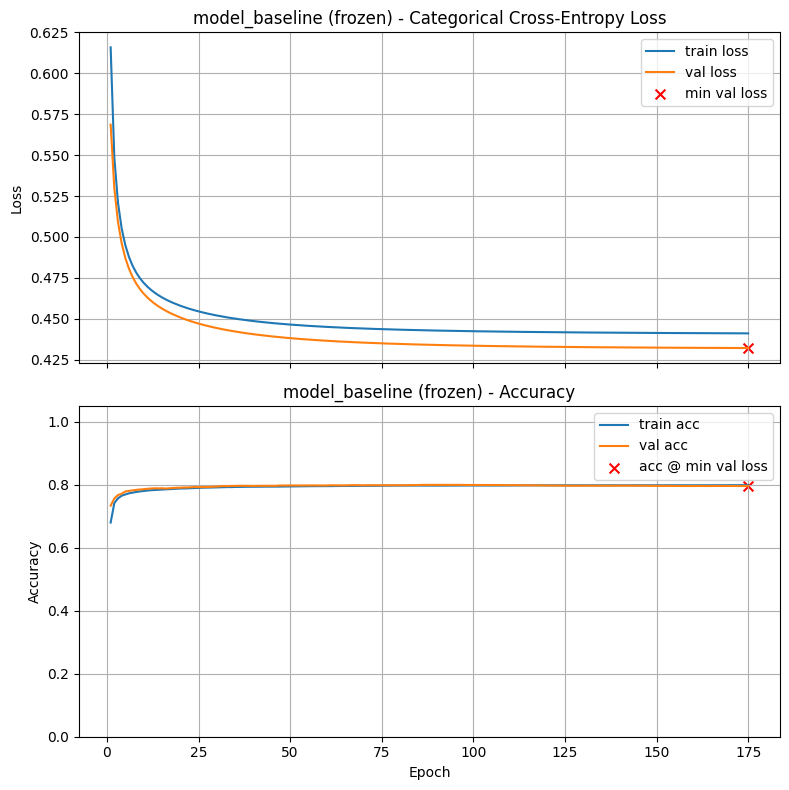


Execution Time: 00:02:15

Final Training Loss:            0.4410
Final Training Accuracy:        0.7985
Final Validation Loss:          0.4321
Final Validation Accuracy:      0.7959
Minimum Validation Loss:        0.4321 (Epoch 175)
Validation Accuracy @ Min Loss: 0.7959

Test Loss: 0.4330
Test Accuracy: 0.8075

Validation-Test Accuracy Gap: 0.011625


In [11]:

model_baseline_frozen = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,                      # ignore <PAD> in pooling -- this makes a huge difference in training speed!
        trainable  = False                      # freeze or unfreeze embedding weights
    ),
    GlobalAveragePooling1D(),                        # take average along each dimension
    Dense(1, activation='sigmoid')
])


train_and_test(model_baseline_frozen,  lr_schedule=1e-2, title="model_baseline (frozen)")

#### End of Template Code from Coding Notebook

## Problem One: Baseline with Unfrozen Embeddings

**ToDo:**

1. Establish a baseline for unfrozen embeddings by running the baseline model but with `trainable = True` to retrain the embeddings as it trains on the the classification task. You will use retrainable embeddings throughout the homework.

2. Now run 2-3 experiments to try to improve this baseline:

    - Consider adding a Dense layer between the global average pooling and the output layer, with
        - Your choice of size
        - Your choice of L2 regularizatio (or not)
        - Your choice of dropout (or not)
3. As needed, tweak the learning rate (try `1e-4`) and try it with or without Reduce on Plateau (you can tweak the parameters there as well)
4. Define your best model for unfrozen embeddings based on these experiments (you will use it in the remaining two problems)
5. Answer the graded questions

**Note:** Generally, you will need a lower learning rate for retrainable embeddings.


Baseline (Unfrozen Embeddings)


Epoch 105: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


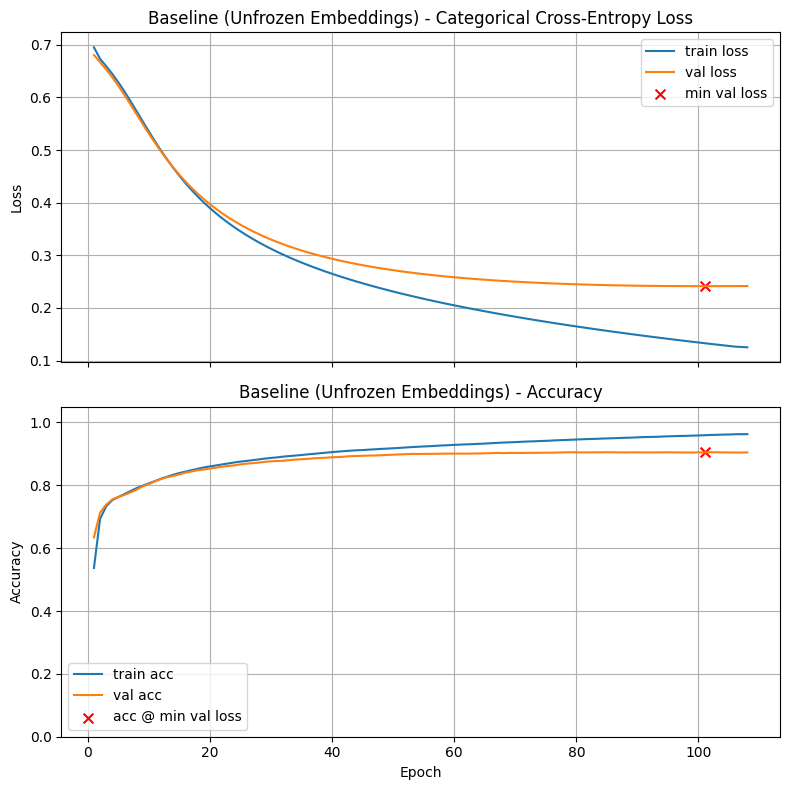


Execution Time: 00:02:25

Final Training Loss:            0.1253
Final Training Accuracy:        0.9628
Final Validation Loss:          0.2417
Final Validation Accuracy:      0.9045
Minimum Validation Loss:        0.2414 (Epoch 101)
Validation Accuracy @ Min Loss: 0.9049

Test Loss: 0.2533
Test Accuracy: 0.8999

Validation-Test Accuracy Gap: 0.004975

Unfrozen + Hidden(64) + L2 + Dropout


Epoch 39: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


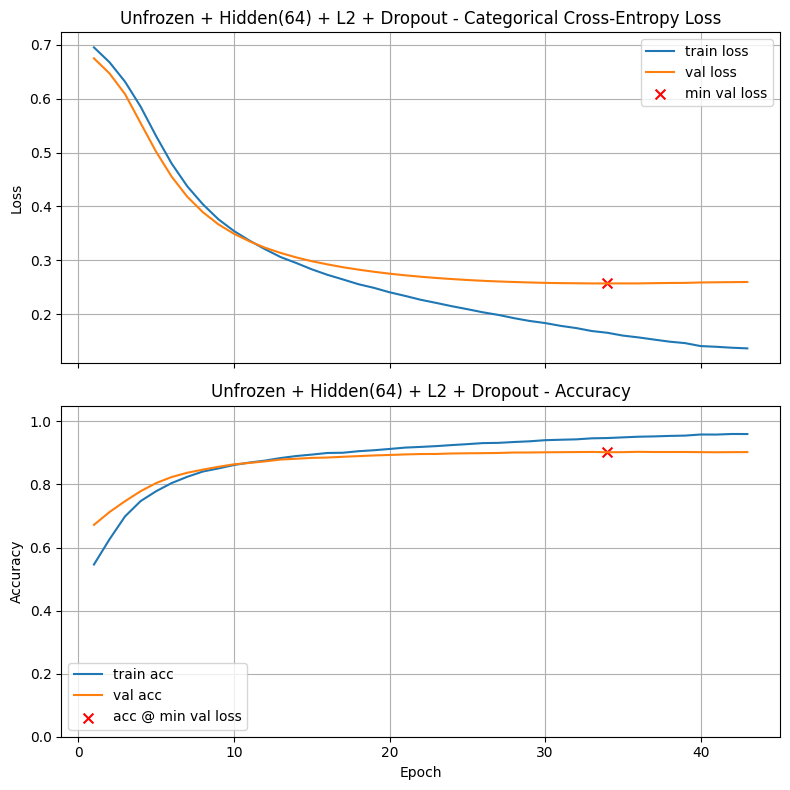


Execution Time: 00:01:04

Final Training Loss:            0.1367
Final Training Accuracy:        0.9599
Final Validation Loss:          0.2599
Final Validation Accuracy:      0.9026
Minimum Validation Loss:        0.2572 (Epoch 34)
Validation Accuracy @ Min Loss: 0.9021

Test Loss: 0.2724
Test Accuracy: 0.8986

Validation-Test Accuracy Gap: 0.003525


In [12]:
# Your code here; add as many cells as you need
trainable = True
model_unfrozen_baseline = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])
train_and_test(model_unfrozen_baseline,
               lr_schedule=1e-4,
               title="Baseline (Unfrozen Embeddings)",
               callbacks=[reduce_lr])
from tensorflow.keras.regularizers import l2

model_with_hidden = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
train_and_test(model_with_hidden,
               lr_schedule=1e-4,
               title="Unfrozen + Hidden(64) + L2 + Dropout",
               callbacks=[reduce_lr])


### Graded Questions

#### Question a1a:

In [29]:
# Set a1a to the validation accuracy for your best model found in this problem

a1a = 0.9021          # Replace 0.0 with your answer

In [30]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a:.4f}')

a1a = 0.9021


#### Question a1b: Describe below your experiments. What worked and what didn't?    

#### Your Answer Here:
In part 1, base on the instructions given, I started a baseline model with unfrozen GloVe embeddings and a single output layer. This model achieved strong performance with a validation accuracy at minimum loss of **0.9021** and a small validation-test accuracy gap, which means a pretty good generalization. I then added a hidden layer with 64 units, L2 regularization, and dropout (0.3) to see if this could improve performance further. While this modified model maintained similar accuracy (**0.9021**) and generalization, it did not really outperform the original simpler baseline. This means that the original unfrozen embeddings already provided strong semantic representations, and adding more tuning or hyperparameters did not yield substantial gains. The lower learning rate 1e-4`and ReduceLROnPlateau callback also contributed to stable training in both models. Overall, unfrozen embeddings clearly helped over the frozen baseline, while architectural tweaks had only marginal effects.





## Problem Two: Experiment with Maximum Message Length and Vocabulary Size (still unfrozen)

We might expect that increasing the amount of data by increasing the maximum message length and the vocabulary size would improve results,
but maybe not, or maybe not as much as you would expect. Let's find out!

**ToDo:**

1. Start with your best model from Problem One

2. Consult the information shown in the EDA cells above, and run 2-3 experiments to try to improve this model by increasing either or both of:

    - `max_text_length`, and
    - `training_vocabulary_size`
3. As needed, tweak the learning rate and try it with or without Reduce on Plateau (you can tweak the parametera there as well)
4. Define your best model for use in Problem Three
5. Answer the graded questions

**Note:** `train_and_test` accesses the training and testing files as globals. You can cut and paste copies of the cells which load, preprocess, and build the embeddings for the dataset,
but you'll be **redefining the global names,** just be careful about the order in which you run cells. As an alternative, you can change the parameters in the code in the Prelude, and
just run this problem here.



==== Running experiment: vocab=20000, maxlen=500 ====

vocab=20000, maxlen=500


Epoch 42: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


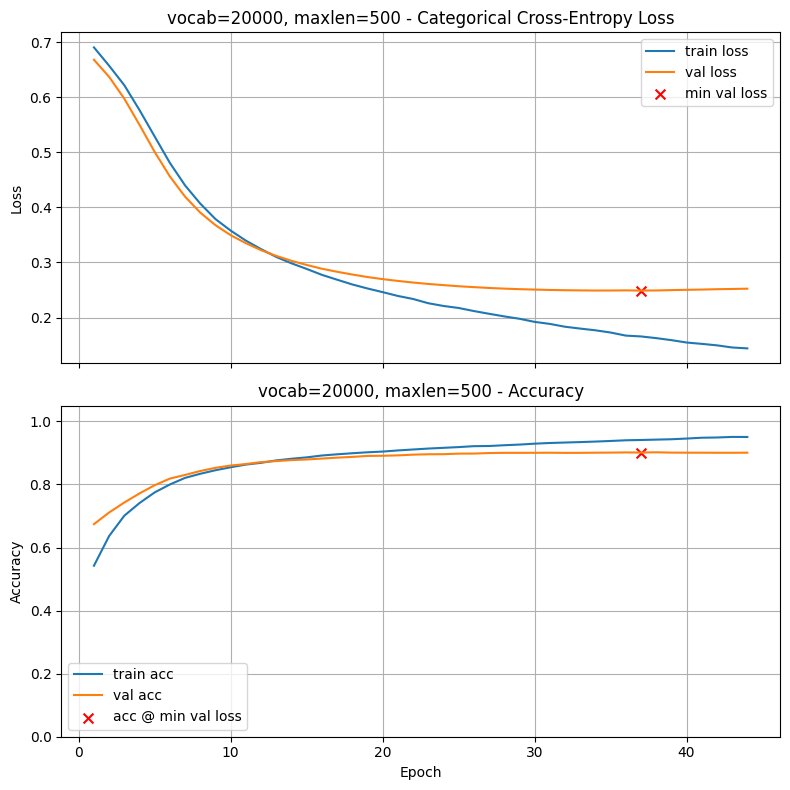


Execution Time: 00:01:00

Final Training Loss:            0.1440
Final Training Accuracy:        0.9506
Final Validation Loss:          0.2523
Final Validation Accuracy:      0.9007
Minimum Validation Loss:        0.2490 (Epoch 37)
Validation Accuracy @ Min Loss: 0.9011

Test Loss: 0.2621
Test Accuracy: 0.8977

Validation-Test Accuracy Gap: 0.003425


==== Running experiment: vocab=20000, maxlen=800 ====

vocab=20000, maxlen=800


Epoch 42: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 47: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


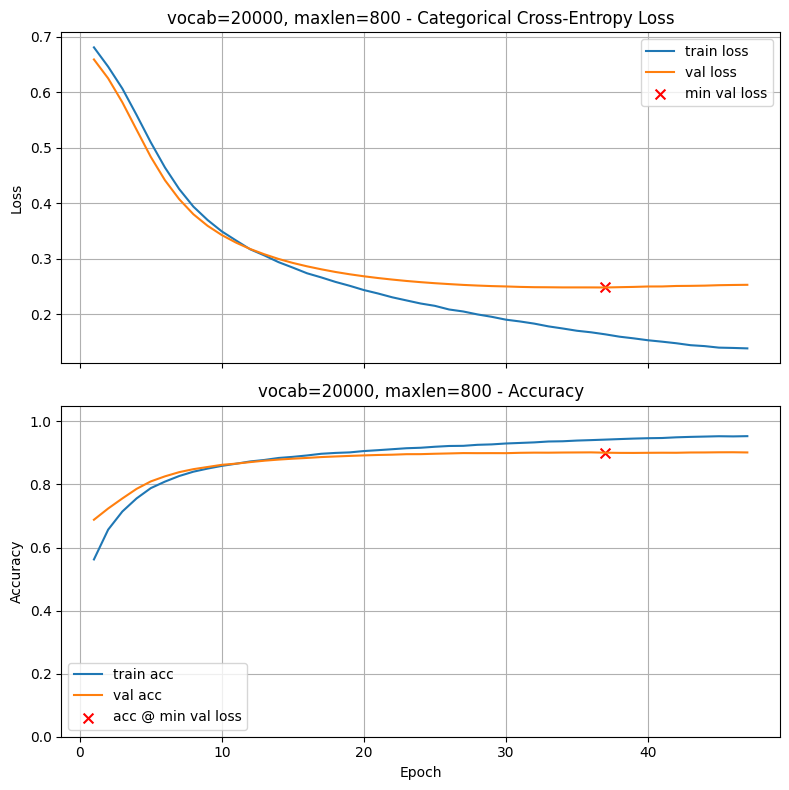


Execution Time: 00:01:21

Final Training Loss:            0.1381
Final Training Accuracy:        0.9532
Final Validation Loss:          0.2527
Final Validation Accuracy:      0.9015
Minimum Validation Loss:        0.2479 (Epoch 37)
Validation Accuracy @ Min Loss: 0.9007

Test Loss: 0.2601
Test Accuracy: 0.8988

Validation-Test Accuracy Gap: 0.001950


==== Running experiment: vocab=20000, maxlen=1000 ====

vocab=20000, maxlen=1000


Epoch 41: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 46: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


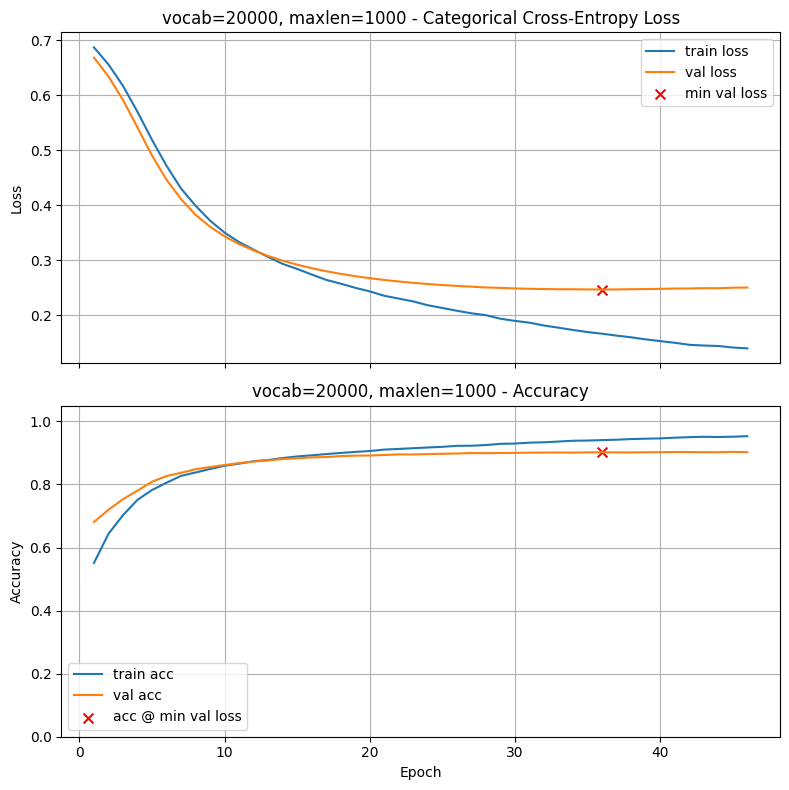


Execution Time: 00:01:32

Final Training Loss:            0.1400
Final Training Accuracy:        0.9530
Final Validation Loss:          0.2505
Final Validation Accuracy:      0.9022
Minimum Validation Loss:        0.2469 (Epoch 36)
Validation Accuracy @ Min Loss: 0.9020

Test Loss: 0.2594
Test Accuracy: 0.9000

Validation-Test Accuracy Gap: 0.002000


==== Running experiment: vocab=50000, maxlen=500 ====

vocab=50000, maxlen=500


Epoch 38: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 43: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


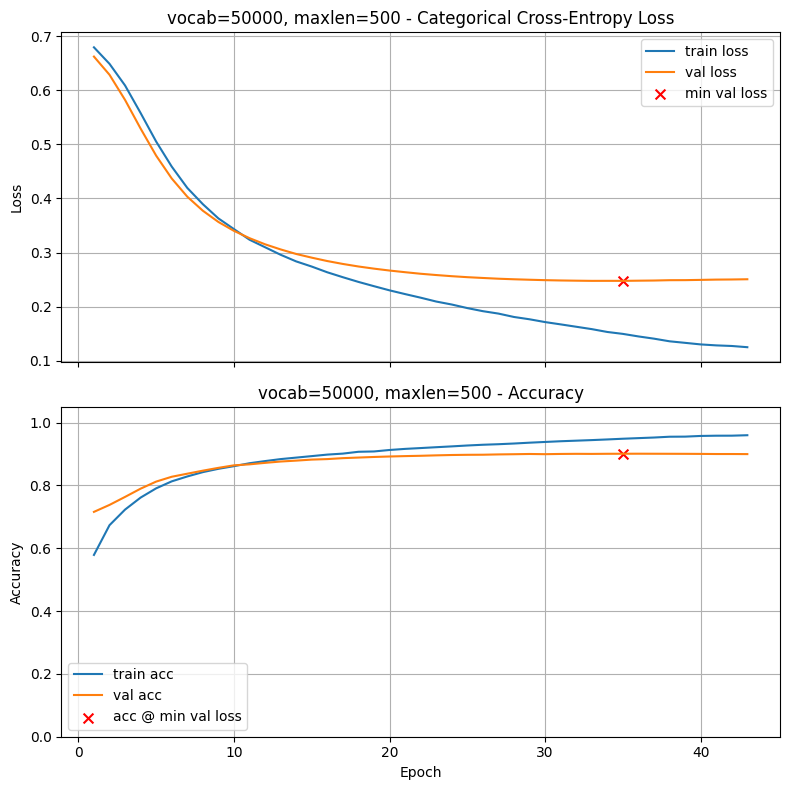


Execution Time: 00:01:05

Final Training Loss:            0.1252
Final Training Accuracy:        0.9597
Final Validation Loss:          0.2507
Final Validation Accuracy:      0.8996
Minimum Validation Loss:        0.2477 (Epoch 35)
Validation Accuracy @ Min Loss: 0.9007

Test Loss: 0.2592
Test Accuracy: 0.8985

Validation-Test Accuracy Gap: 0.002250


==== Running experiment: vocab=50000, maxlen=800 ====

vocab=50000, maxlen=800


Epoch 40: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 45: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


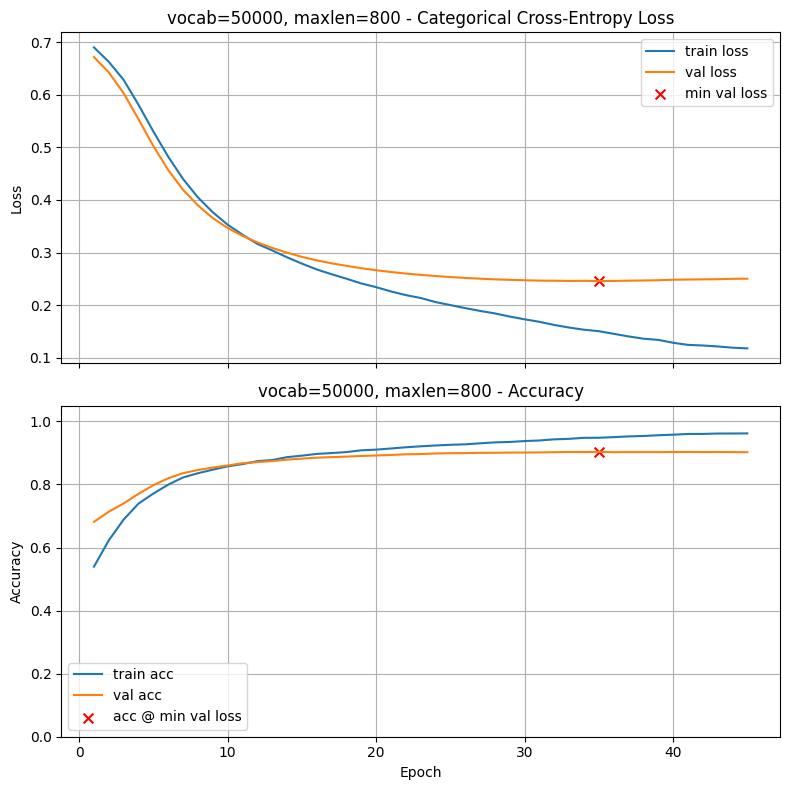


Execution Time: 00:01:23

Final Training Loss:            0.1179
Final Training Accuracy:        0.9619
Final Validation Loss:          0.2503
Final Validation Accuracy:      0.9022
Minimum Validation Loss:        0.2458 (Epoch 35)
Validation Accuracy @ Min Loss: 0.9034

Test Loss: 0.2591
Test Accuracy: 0.9001

Validation-Test Accuracy Gap: 0.003275


==== Running experiment: vocab=50000, maxlen=1000 ====

vocab=50000, maxlen=1000


Epoch 40: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 45: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


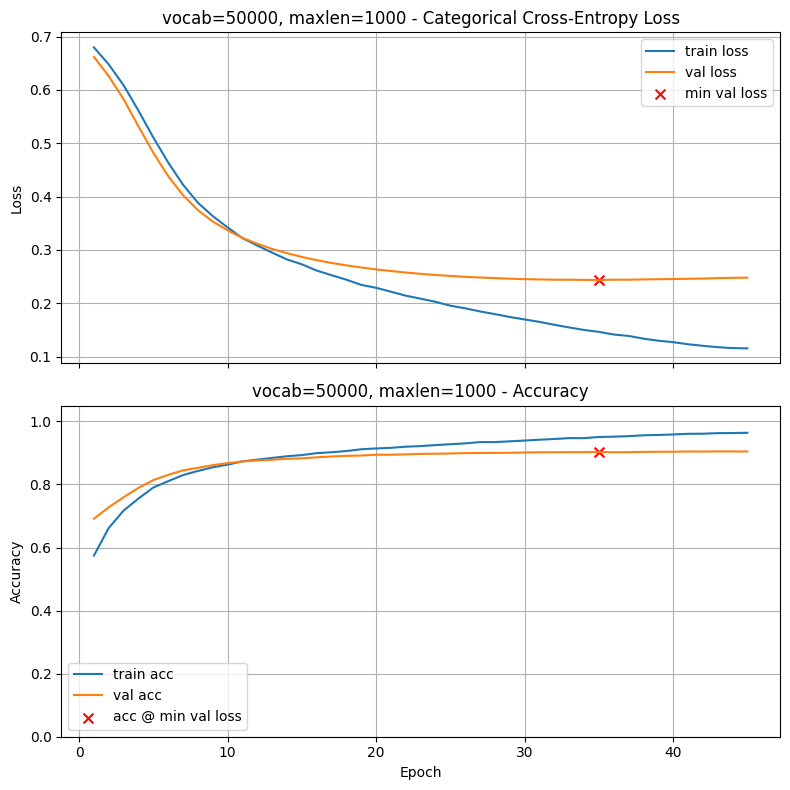


Execution Time: 00:01:37

Final Training Loss:            0.1153
Final Training Accuracy:        0.9638
Final Validation Loss:          0.2479
Final Validation Accuracy:      0.9045
Minimum Validation Loss:        0.2434 (Epoch 35)
Validation Accuracy @ Min Loss: 0.9031

Test Loss: 0.2576
Test Accuracy: 0.8997

Validation-Test Accuracy Gap: 0.003425


==== Running experiment: vocab=88584, maxlen=500 ====

vocab=88584, maxlen=500


Epoch 38: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 43: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


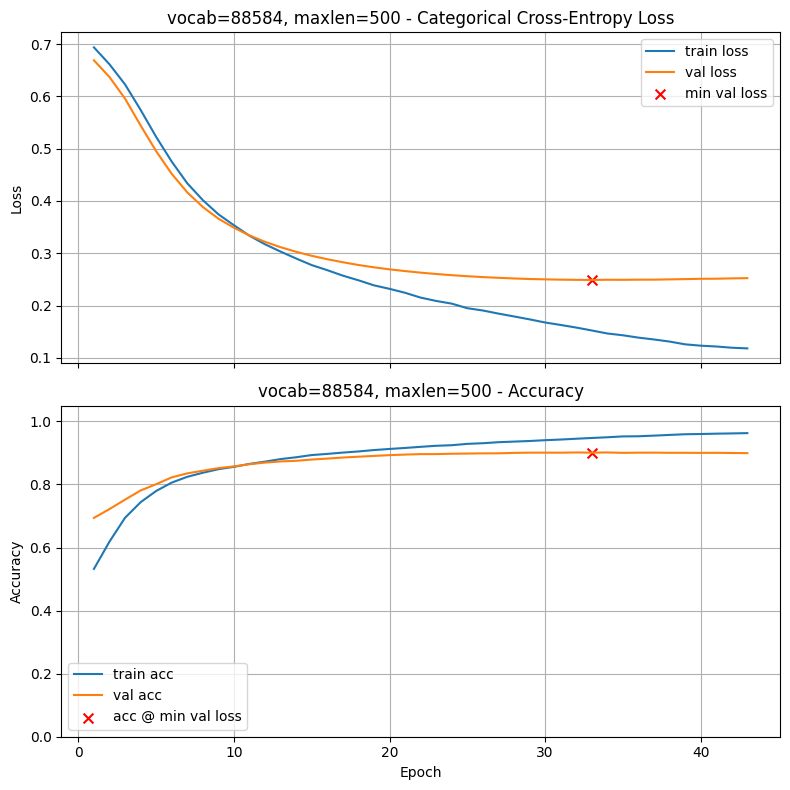


Execution Time: 00:01:10

Final Training Loss:            0.1183
Final Training Accuracy:        0.9628
Final Validation Loss:          0.2526
Final Validation Accuracy:      0.8994
Minimum Validation Loss:        0.2491 (Epoch 33)
Validation Accuracy @ Min Loss: 0.9009

Test Loss: 0.2605
Test Accuracy: 0.8990

Validation-Test Accuracy Gap: 0.001875


==== Running experiment: vocab=88584, maxlen=800 ====

vocab=88584, maxlen=800


Epoch 40: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 45: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


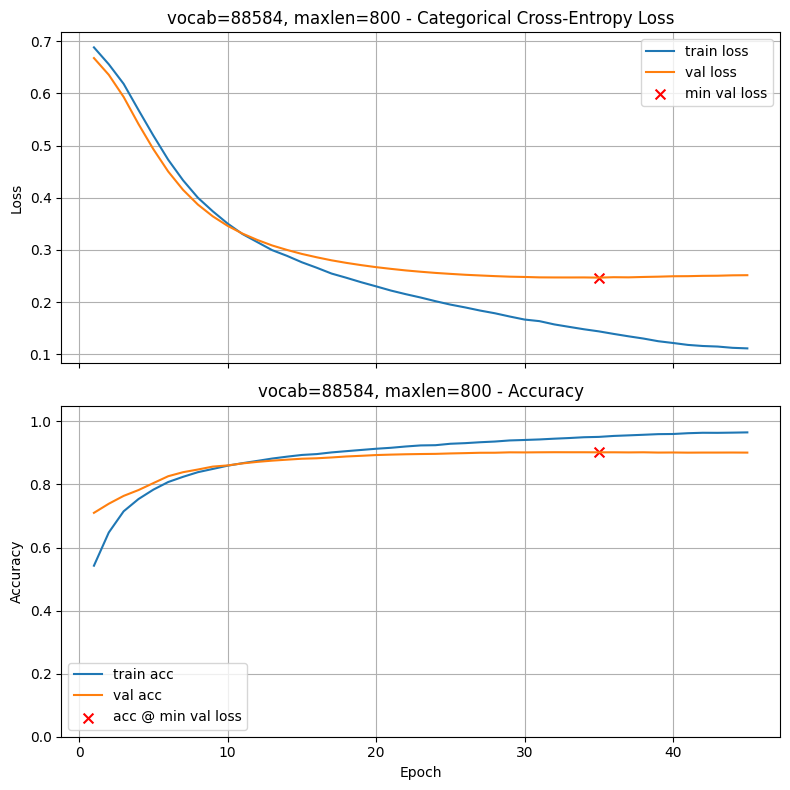


Execution Time: 00:01:33

Final Training Loss:            0.1113
Final Training Accuracy:        0.9651
Final Validation Loss:          0.2516
Final Validation Accuracy:      0.9010
Minimum Validation Loss:        0.2469 (Epoch 35)
Validation Accuracy @ Min Loss: 0.9019

Test Loss: 0.2578
Test Accuracy: 0.9019

Validation-Test Accuracy Gap: 0.000025


==== Running experiment: vocab=88584, maxlen=1000 ====

vocab=88584, maxlen=1000


Epoch 41: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 46: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


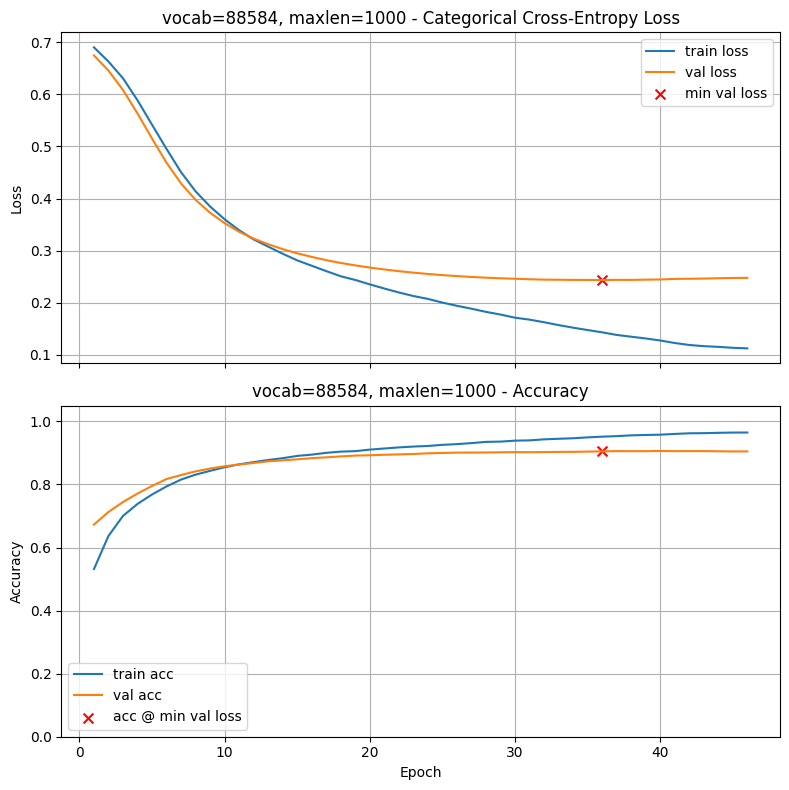


Execution Time: 00:01:47

Final Training Loss:            0.1123
Final Training Accuracy:        0.9647
Final Validation Loss:          0.2476
Final Validation Accuracy:      0.9049
Minimum Validation Loss:        0.2435 (Epoch 36)
Validation Accuracy @ Min Loss: 0.9049

Test Loss: 0.2598
Test Accuracy: 0.9000

Validation-Test Accuracy Gap: 0.004875


In [19]:
# Your code here; add as many cells as you need
from itertools import product

embedding_dimension = 100
word_index = imdb.get_word_index()

glove_path = Path(f"glove.6B/glove.6B.{embedding_dimension}d.txt")
embeddings_index = {}
with glove_path.open(encoding='utf8') as f:
    for line in f:
        word, *vec = line.split()
        embeddings_index[word] = np.asarray(vec, dtype='float32')

def build_best_model():
    return Sequential([
        Input(shape=(max_text_length,), dtype='int32'),
        Embedding(
            input_dim=training_vocabulary_size,
            output_dim=embedding_dimension,
            weights=[embedding_matrix],
            mask_zero=True,
            trainable=True
        ),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

vocab_sizes = [20000, 50000, 88584]
text_lengths = [500, 800, 1000]


for training_vocabulary_size, max_text_length in product(vocab_sizes, text_lengths):
    print(f"\n\n==== Running experiment: vocab={training_vocabulary_size}, maxlen={max_text_length} ====")

    (X_tr, y_tr), (X_te, y_te) = imdb.load_data(num_words=training_vocabulary_size)
    X = np.concatenate([X_tr, X_te], axis=0)
    y = np.concatenate([y_tr, y_te], axis=0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_seed, stratify=y
    )

    X_train = pad_sequences(X_train, maxlen=max_text_length, padding='post', truncating='post')
    X_test = pad_sequences(X_test, maxlen=max_text_length, padding='post', truncating='post')

    embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))
    for word, raw_idx in word_index.items():
        idx = raw_idx + 3
        if idx < training_vocabulary_size:
            vec = embeddings_index.get(word)
            if vec is not None:
                embedding_matrix[idx] = vec

    model = build_best_model()
    title = f"vocab={training_vocabulary_size}, maxlen={max_text_length}"

    train_and_test(model,
                   title=title,
                   lr_schedule=1e-4,
                   callbacks=[reduce_lr])


### Graded Questions

In [20]:
# Set a1a to the validation accuracy for your best model found in this problem

a2a = 0.9049            # Replace 0.0 with your answer

In [21]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a:.4f}')

a2a = 0.9049


#### Question a2b: Describe below your experiments. What effect did your changes to the dataset have? Did it help as you as you expected?   

### Your Answer Here: In Part 2, I tested the effect of changing the vocabulary size and looking at messaage length. I changed from 20000, to 50000, and to the actual 88584 which is the full piece. I also targeted the maximum text lengths from 500, to 800 to 1000. Due to all the different configurations, instead of running the code every time and copying each section with different vocabulary sizes and lengths, I decided to do loops insead of writing each section of code. The following are the Validation Accuracy at Minimum Loss with the vocabulary size, and maximum text lengths. Base on the validation accuracy, the following are:
*   **[0.9031 (20000, 500)]**,
*   **[0.9011 (20000, 800)]**,
*   **[0.9007 (20000,1000)]**,
*   **[0.9022 (50000, 500)]**,
*   **[0.9007 (50000, 800)]**,
*   **[0.9034 (50000, 1000)]**,
*   **[0.9031 (88584, 500)]**,
*   **[0.9009 (88584, 800)]**,
*   **[0.9049 (88584, 1000)]**

### Validation accuracy are closely related, all of it is technically 0.90 with various it fluxuates up and down with 88584 and 1000 being the highest validation accuracy.





## Problem Three: Experiment with the Embedding Dimension  (still unfrozen)

We might expect that increasing the embedding dimension would improve your results!
Again, maybe not, or maybe not as much as you would expect. Let's find out!

**ToDo:**

1. Start with your best model from Problem Two (which used an embedding dimension of 100)
2. Try an embedding dimension of 300 to see the effect. (Optional: Try 50 and 200 as well.)
3. As necessary weak the learning rate and try it with or without Reduce on Plateau (you can tweak the parameters there as well)
4. Answer the graded questions



==== Running experiment: embedding_dim=50 ====

embedding_dim=50


Epoch 49: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 54: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


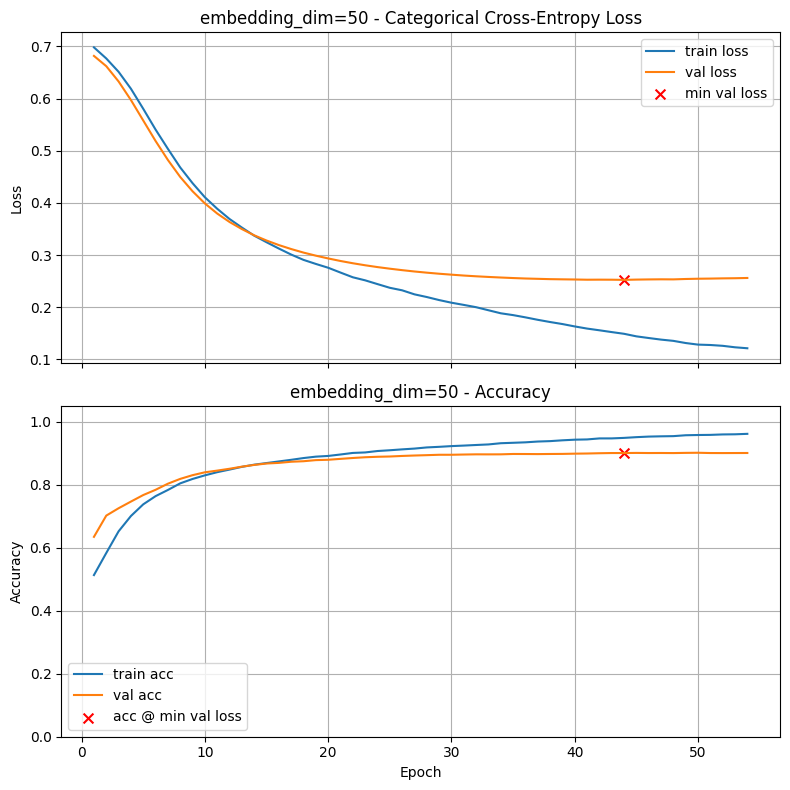


Execution Time: 00:01:20

Final Training Loss:            0.1212
Final Training Accuracy:        0.9609
Final Validation Loss:          0.2560
Final Validation Accuracy:      0.9001
Minimum Validation Loss:        0.2523 (Epoch 44)
Validation Accuracy @ Min Loss: 0.9000

Test Loss: 0.2603
Test Accuracy: 0.8986

Validation-Test Accuracy Gap: 0.001400


==== Running experiment: embedding_dim=100 ====

embedding_dim=100


Epoch 39: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 44: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


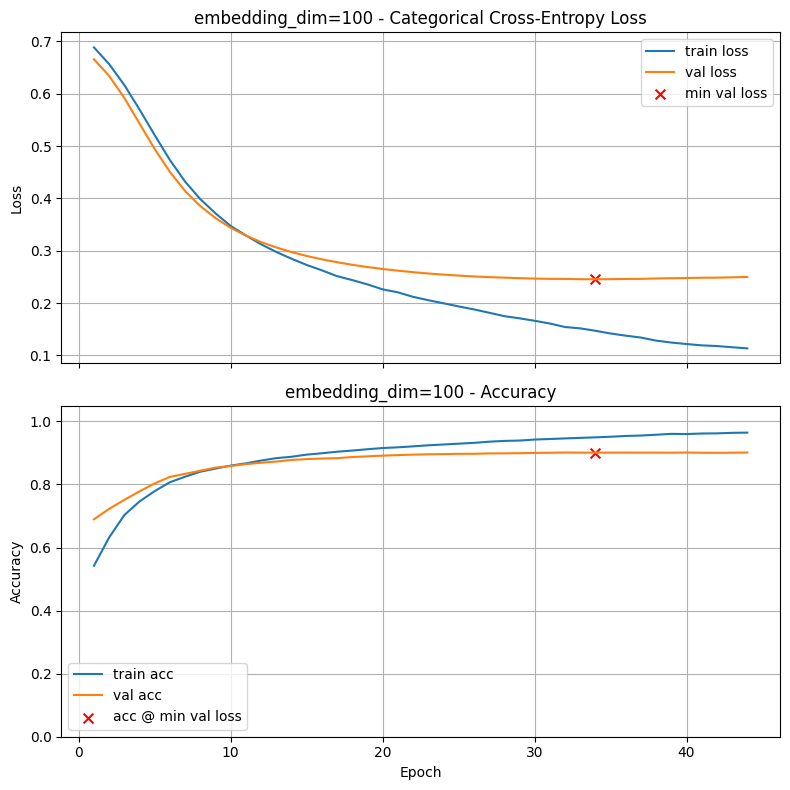


Execution Time: 00:01:43

Final Training Loss:            0.1136
Final Training Accuracy:        0.9643
Final Validation Loss:          0.2501
Final Validation Accuracy:      0.9014
Minimum Validation Loss:        0.2456 (Epoch 34)
Validation Accuracy @ Min Loss: 0.9009

Test Loss: 0.2580
Test Accuracy: 0.9004

Validation-Test Accuracy Gap: 0.000475


==== Running experiment: embedding_dim=200 ====

embedding_dim=200


Epoch 29: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 34: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


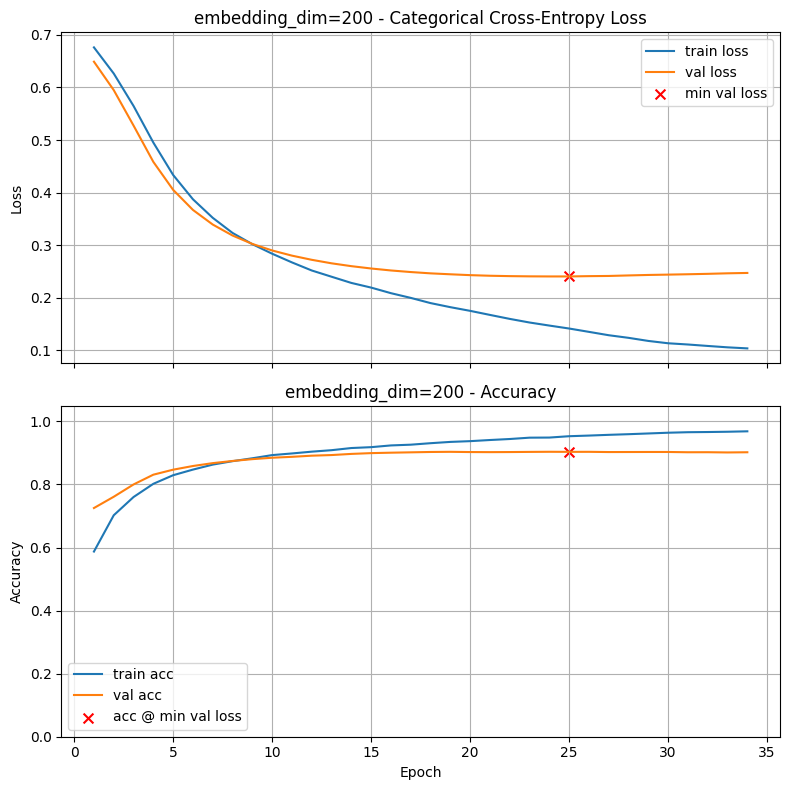


Execution Time: 00:03:04

Final Training Loss:            0.1039
Final Training Accuracy:        0.9685
Final Validation Loss:          0.2473
Final Validation Accuracy:      0.9021
Minimum Validation Loss:        0.2407 (Epoch 25)
Validation Accuracy @ Min Loss: 0.9034

Test Loss: 0.2534
Test Accuracy: 0.9018

Validation-Test Accuracy Gap: 0.001575


==== Running experiment: embedding_dim=300 ====

embedding_dim=300


Epoch 24: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 29: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


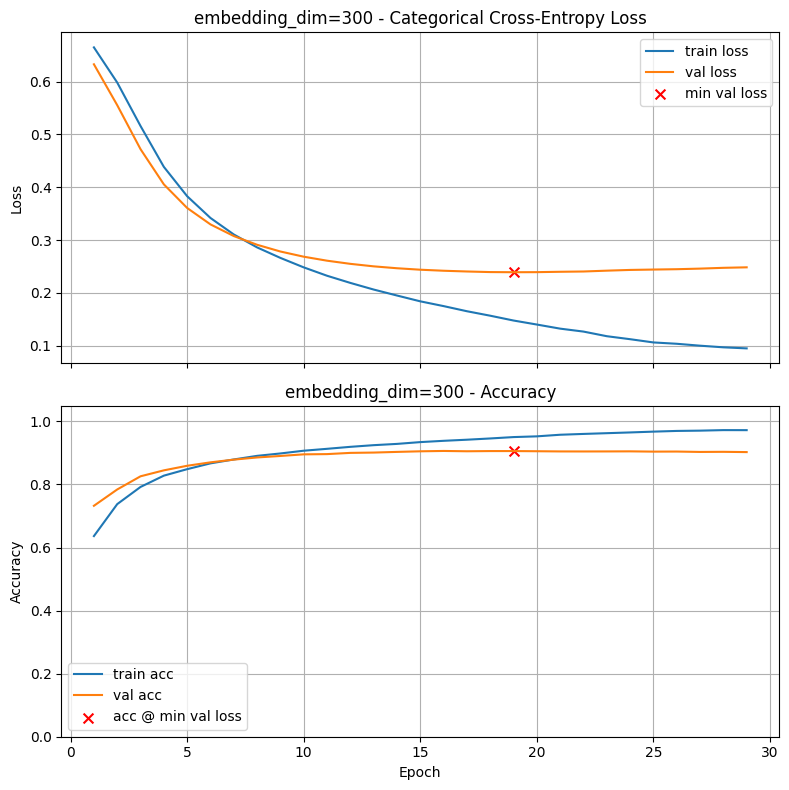


Execution Time: 00:03:07

Final Training Loss:            0.0949
Final Training Accuracy:        0.9722
Final Validation Loss:          0.2484
Final Validation Accuracy:      0.9026
Minimum Validation Loss:        0.2391 (Epoch 19)
Validation Accuracy @ Min Loss: 0.9059

Test Loss: 0.2518
Test Accuracy: 0.9035

Validation-Test Accuracy Gap: 0.002375


✅ All Results for Problem Three (Sorted by Validation Accuracy):

embedding_dim=300                       	0.9059	19
Baseline (Unfrozen Embeddings)          	0.9049	101
vocab=88584, maxlen=1000                	0.9049	36
vocab=50000, maxlen=800                 	0.9034	35
embedding_dim=200                       	0.9034	25
vocab=50000, maxlen=1000                	0.9031	35
maxlen=1000, vocab=88584                	0.9028	33
Unfrozen + Hidden(64) + L2 + Dropout    	0.9021	34
vocab=20000, maxlen=1000                	0.9020	36
vocab=88584, maxlen=800                 	0.9019	35
vocab=20000, maxlen=500                 	0.9011	37
vocab=88584, maxl

In [24]:
# Your code here; add as many cells as you need
from pathlib import Path
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np


best_vocabulary_size = 88584
best_text_length     = 1000
embedding_dims_to_try = [50, 100, 200, 300]

word_index = imdb.get_word_index()

def build_model_with_embedding():
    return Sequential([
        Input(shape=(best_text_length,), dtype='int32'),
        Embedding(
            input_dim=best_vocabulary_size,
            output_dim=embedding_dimension,
            weights=[embedding_matrix],
            mask_zero=True,
            trainable=True
        ),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])


(X_tr, y_tr), (X_te, y_te) = imdb.load_data(num_words=best_vocabulary_size)
X = np.concatenate([X_tr, X_te], axis=0)
y = np.concatenate([y_tr, y_te], axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)

X_train = pad_sequences(X_train, maxlen=best_text_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=best_text_length, padding='post', truncating='post')


for embedding_dimension in embedding_dims_to_try:
    print(f"\n\n==== Running experiment: embedding_dim={embedding_dimension} ====")

    glove_path = Path(f"glove.6B/glove.6B.{embedding_dimension}d.txt")
    if not glove_path.exists():
        print(f"GloVe file not found: {glove_path}")
        continue

    embeddings_index = {}
    with glove_path.open(encoding='utf8') as f:
        for line in f:
            word, *vec = line.split()
            embeddings_index[word] = np.asarray(vec, dtype='float32')

    embedding_matrix = np.zeros((best_vocabulary_size, embedding_dimension))
    for word, raw_idx in word_index.items():
        idx = raw_idx + 3
        if idx < best_vocabulary_size:
            vec = embeddings_index.get(word)
            if vec is not None:
                embedding_matrix[idx] = vec

    model = build_model_with_embedding()
    title = f"embedding_dim={embedding_dimension}"

    train_and_test(
        model,
        title=title,
        lr_schedule=1e-4,
        callbacks=[reduce_lr]
    )


print("\n\nAll Results for Problem Three (Sorted by Validation Accuracy):\n")
print_results()



### Graded Questions

In [25]:
# Set a1a to the validation accuracy for your best model found in this problem

a3a = 0.9059             # Replace 0.0 with your answer

In [26]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a:.4f}')

a3a = 0.9059


#### Question a3b: Describe below your experiments. What effect did increasing the dimension from 100 to 300 have? Did it help as you as you expected?  

#### Your Answer Here:
In this experiment, I think the effect of increasing the GloVe embedding dimension from actually 50 to 300 and kept the rest of the model consistent. I found that validation accuracy improved as the dimension increased, with the best performance at 300 dimensions **0.9059**, slightly outperforming the 100-dimensional setup from Problem Two **0.9009**. The improvements is kind of what I expected as higher-dimensional embeddings can capture more information. However, the gains diminished at higher dimensions, which might mean that while increasing embedding size is beneficial up to a point, it offers only modest improvements beyond 200 dimensions, it kind of platueaus out.



In [27]:
print_results()

embedding_dim=300                       	0.9059	19
Baseline (Unfrozen Embeddings)          	0.9049	101
vocab=88584, maxlen=1000                	0.9049	36
vocab=50000, maxlen=800                 	0.9034	35
embedding_dim=200                       	0.9034	25
vocab=50000, maxlen=1000                	0.9031	35
maxlen=1000, vocab=88584                	0.9028	33
Unfrozen + Hidden(64) + L2 + Dropout    	0.9021	34
vocab=20000, maxlen=1000                	0.9020	36
vocab=88584, maxlen=800                 	0.9019	35
vocab=20000, maxlen=500                 	0.9011	37
vocab=88584, maxlen=500                 	0.9009	33
embedding_dim=100                       	0.9009	34
vocab=20000, maxlen=800                 	0.9007	37
vocab=50000, maxlen=500                 	0.9007	35
embedding_dim=50                        	0.9000	44
model_baseline (frozen)                 	0.7959	175


In [28]:
# This will have recorded details of all your experiments

parameter_settings

{'model_baseline (frozen)': [{'title': 'model_baseline (frozen)',
   'timestamp': '2025-10-18T00:31:21',
   'epochs': 200,
   'optimizer': 'Adam',
   'lr_schedule': 0.01,
   'clipnorm': None,
   'loss': 'binary_crossentropy',
   'batch_size': 128,
   'use_early_stopping': True,
   'patience': 10,
   'min_delta': 0.0001,
   'callbacks': [],
   'Final Training Loss': 0.44103384017944336,
   'Final Training Accuracy': 0.7985000014305115,
   'Final Val Loss': 0.43205389380455017,
   'Final Val Accuracy': 0.7958750128746033,
   'Min Val Loss': 0.43205389380455017,
   'Min Val Loss Epoch': np.int64(174),
   'Val Acc @ Min Loss': 0.7958750128746033,
   'Test Loss': 0.4330088794231415,
   'Test Acc': 0.8075000047683716,
   'Val-Test Accuracy Gap:': 0.01162499189376831}],
 'Baseline (Unfrozen Embeddings)': [{'title': 'Baseline (Unfrozen Embeddings)',
   'timestamp': '2025-10-18T00:33:55',
   'epochs': 200,
   'optimizer': 'Adam',
   'lr_schedule': 0.0001,
   'clipnorm': None,
   'loss': 'binary